In [9]:
import os, h5py, yaml, math, datetime, numpy as np, pandas as pd
import torchvision.transforms as transforms
import random
import torchvision.transforms.functional as TF
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset as TorchDataset, DataLoader, random_split
from pytorch_lightning import LightningDataModule, seed_everything
from sevir_dataloader import SEVIRDataLoader
from typing import *
from types import SimpleNamespace
from tqdm import tqdm
from einops import rearrange
from functools import partial
from collections import namedtuple

device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
SEVIR_DATA_DIR = "FlowDAS/experiments/weather_forecasting/data/sevir_lr"
CKPT_PATH = "FlowDAS/experiments/weather_forecasting/checkpoints/latest.pt"
IN_LEN = 6 # Number of input frames needed for trained model
OUT_LEN = 6 # Number of output frames to predict. IN_LEN + OUT_LEN must be no greater than 25.
EM_STEPS = 200
OBS_RATIO = 0.25
OBS_STD = 0.1
OFFSET = 0.5 # Offset value for data normalization (value used in original code)
SCALE = 0.1 # Scale value for data normalization (value used in original code)

# Get Dataloaders

In [10]:
class TransformsFixRotation(nn.Module):
    r"""
    Rotate by one of the given angles.

    Example: `rotation_transform = MyRotationTransform(angles=[-30, -15, 0, 15, 30])`
    """

    def __init__(self, angles):
        super(TransformsFixRotation, self).__init__()
        if not isinstance(angles, Sequence):
            angles = [angles, ]
        self.angles = angles

    def forward(self, x):
        angle = random.choice(self.angles)
        return TF.rotate(x, angle)

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(angles={self.angles})"


class SEVIRTorchDataset(TorchDataset):
    orig_dataloader_layout = "NHWT"
    orig_dataloader_squeeze_layout = orig_dataloader_layout.replace("N", "")
    aug_layout = "THW"

    def __init__(self,
                 seq_len: int = 25,
                 raw_seq_len: int = 49,
                 sample_mode: str = "sequent",
                 stride: int = 12,
                 layout: str = "THWC",
                 split_mode: str = "uneven",
                 sevir_catalog: Union[str, pd.DataFrame] = None,
                 sevir_data_dir: str = None,
                 start_date: datetime.datetime = None,
                 end_date: datetime.datetime = None,
                 datetime_filter = None,
                 catalog_filter = "default",
                 shuffle: bool = False,
                 shuffle_seed: int = 1,
                 output_type = np.float32,
                 preprocess: bool = True,
                 rescale_method: str = "01",
                 verbose: bool = False,
                 aug_mode: str = "0",
                 ret_contiguous: bool = True):
        super(SEVIRTorchDataset, self).__init__()
        self.layout = layout.replace("C", "1")
        self.ret_contiguous = ret_contiguous
        self.sevir_dataloader = SEVIRDataLoader(
            data_types=["vil", ],
            seq_len=seq_len,
            raw_seq_len=raw_seq_len,
            sample_mode=sample_mode,
            stride=stride,
            batch_size=1,
            layout=self.orig_dataloader_layout,
            num_shard=1,
            rank=0,
            split_mode=split_mode,
            sevir_catalog=sevir_catalog,
            sevir_data_dir=sevir_data_dir,
            start_date=start_date,
            end_date=end_date,
            datetime_filter=datetime_filter,
            catalog_filter=catalog_filter,
            shuffle=shuffle,
            shuffle_seed=shuffle_seed,
            output_type=output_type,
            preprocess=preprocess,
            rescale_method=rescale_method,
            downsample_dict=None,
            verbose=verbose)
        self.aug_mode = aug_mode
        if aug_mode == "0":
            self.aug = lambda x:x
        elif aug_mode == "1":
            self.aug = nn.Sequential(
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomRotation(degrees=180),
            )
        elif aug_mode == "2":
            self.aug = nn.Sequential(
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                TransformsFixRotation(angles=[0, 90, 180, 270]),
            )
        else:
            raise NotImplementedError

    def __getitem__(self, index):
        data_dict = self.sevir_dataloader._idx_sample(index=index)
        data = data_dict["vil"].squeeze(0)
        if self.aug_mode != "0":
            data = rearrange(data, f"{' '.join(self.orig_dataloader_squeeze_layout)} -> {' '.join(self.aug_layout)}")
            data = self.aug(data)
            data = rearrange(data, f"{' '.join(self.aug_layout)} -> {' '.join(self.layout)}")
        else:
            data = rearrange(data, f"{' '.join(self.orig_dataloader_squeeze_layout)} -> {' '.join(self.layout)}")
        # print('data', data.shape)
        
        # print('self.ret_contigous', self.ret_contiguous)
        # assert 1==0
        if self.ret_contiguous:
            return data.contiguous()
        else:
            return data

    def __len__(self):
        return self.sevir_dataloader.__len__()


class SEVIRLightningDataModule(LightningDataModule):
    def __init__(self,
                 seq_len: int = 25,
                 sample_mode: str = "sequent",
                 stride: int = 12,
                 layout: str = "NTHWC",
                 output_type = np.float32,
                 preprocess: bool = True,
                 rescale_method: str = "01",
                 verbose: bool = False,
                 aug_mode: str = "0",
                 ret_contiguous: bool = True,
                 # datamodule_only
                 dataset_name: str = "sevir",
                 sevir_dir: str = None,
                 start_date: Tuple[int] = None,
                 train_test_split_date: Tuple[int] = (2019, 6, 1),
                 end_date: Tuple[int] = None,
                 val_ratio: float = 0.1,
                 batch_size: int = 1,
                 num_workers: int = 1,
                 seed: int = 0,
                 ):
        super(SEVIRLightningDataModule, self).__init__()
        
        self.seq_len = seq_len
        self.sample_mode = sample_mode
        self.stride = stride
        assert layout[0] == "N"
        self.layout = layout.replace("N", "")
        self.output_type = output_type
        self.preprocess = preprocess
        self.rescale_method = rescale_method
        self.verbose = verbose
        self.aug_mode = aug_mode
        self.ret_contiguous = ret_contiguous
        self.batch_size = batch_size
        print('batch_size', batch_size)
        # assert 1==0
        self.num_workers = num_workers
        self.seed = seed
        if sevir_dir is not None:
            sevir_dir = os.path.abspath(sevir_dir)
        if dataset_name == "sevir":
            if sevir_dir is None:
                sevir_dir = default_dataset_sevir_dir
            catalog_path = os.path.join(sevir_dir, "CATALOG.csv")
            raw_data_dir = os.path.join(sevir_dir, "data")
            raw_seq_len = 49
            interval_real_time = 5
            img_height = 384
            img_width = 384
        elif dataset_name == "sevirlr":
            if sevir_dir is None:
                sevir_dir = default_dataset_sevirlr_dir
            print('sevir_dir', sevir_dir)
            catalog_path = os.path.join(sevir_dir, "CATALOG.csv")
            raw_data_dir = os.path.join(sevir_dir, "data")
            raw_seq_len = 25
            interval_real_time = 10
            img_height = 128
            img_width = 128
        else:
            raise ValueError(f"Wrong dataset name {dataset_name}. Must be 'sevir' or 'sevirlr'.")
        self.dataset_name = dataset_name
        self.sevir_dir = sevir_dir
        print(' self.sevir_dir',  self.sevir_dir)
        self.catalog_path = catalog_path
        self.raw_data_dir = raw_data_dir
        self.raw_seq_len = raw_seq_len
        self.interval_real_time = interval_real_time
        self.img_height = img_height
        self.img_width = img_width
        # train val test split
        self.start_date = datetime.datetime(*start_date) \
            if start_date is not None else None
        self.train_test_split_date = datetime.datetime(*train_test_split_date) \
            if train_test_split_date is not None else None
        self.end_date = datetime.datetime(*end_date) \
            if end_date is not None else None
        self.val_ratio = val_ratio

    def setup(self, stage = None) -> None:
        seed_everything(seed=self.seed)
        if stage in (None, "fit"):
            sevir_train_val = SEVIRTorchDataset(
                sevir_catalog=self.catalog_path,
                sevir_data_dir=self.raw_data_dir,
                raw_seq_len=self.raw_seq_len,
                split_mode="uneven",
                shuffle=True,
                seq_len=self.seq_len,
                stride=self.stride,
                sample_mode=self.sample_mode,
                layout=self.layout,
                start_date=self.start_date,
                end_date=self.train_test_split_date,
                output_type=self.output_type,
                preprocess=self.preprocess,
                rescale_method=self.rescale_method,
                verbose=self.verbose,
                aug_mode=self.aug_mode,
                ret_contiguous=self.ret_contiguous,)
        
            # Iterate through the dataset
            self.sevir_train, self.sevir_val = random_split(
                dataset=sevir_train_val,
                lengths=[1 - self.val_ratio, self.val_ratio],
                generator=torch.Generator().manual_seed(self.seed))
        if stage in (None, "test"):
            self.sevir_test = SEVIRTorchDataset(
                sevir_catalog=self.catalog_path,
                sevir_data_dir=self.raw_data_dir,
                raw_seq_len=self.raw_seq_len,
                split_mode="uneven",
                shuffle=False,
                seq_len=self.seq_len,
                stride=self.stride,
                sample_mode=self.sample_mode,
                layout=self.layout,
                start_date=self.train_test_split_date,
                end_date=self.end_date,
                output_type=self.output_type,
                preprocess=self.preprocess,
                rescale_method=self.rescale_method,
                verbose=self.verbose,
                aug_mode="0",
                ret_contiguous=self.ret_contiguous,)

    def train_dataloader(self):
        return DataLoader(self.sevir_train,
                          batch_size=self.batch_size,
                          shuffle=True,
                          num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.sevir_val,
                          batch_size=self.batch_size,
                          shuffle=False,
                          num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.sevir_test,
                          batch_size=1,
                          shuffle=False,
                          num_workers=self.num_workers)

    @property
    def num_train_samples(self):
        return len(self.sevir_train)

    @property
    def num_val_samples(self):
        return len(self.sevir_val)

    @property
    def num_test_samples(self):
        return len(self.sevir_test)

In [11]:
dataset_cfg = {'dataset_name': 'sevirlr',
               'img_height': 128,
               'img_width': 128,
               'in_len': IN_LEN,
               'out_len': OUT_LEN,
               'seq_len': IN_LEN + OUT_LEN,
               'plot_stride': 1,
               'interval_real_time': 10,
               'sample_mode': 'sequent',
               'stride': 6,
               'layout': 'NTHWC',
               'start_date': None,
               'train_test_split_date': [2019, 6, 1],
               'end_date': None,
               'val_ratio': 0.1,
               'metrics_mode': '0',
               'metrics_list': ['csi', 'pod', 'sucr', 'bias'],
               'threshold_list': [16, 74, 133, 160, 181, 219],
               'aug_mode': '2', # Apply data augmentation: '1', '2', or not: '0'
               'sevir_dir': SEVIR_DATA_DIR,
               'batch_size': 50,
               'num_workers': 4,}

dm = SEVIRLightningDataModule(
            seq_len=dataset_cfg["seq_len"],
            sample_mode=dataset_cfg["sample_mode"],
            stride=dataset_cfg["stride"],
            batch_size=dataset_cfg["batch_size"],
            layout=dataset_cfg["layout"],
            output_type=np.float32,
            preprocess=True,
            rescale_method="01",
            verbose=False,
            aug_mode=dataset_cfg["aug_mode"],
            ret_contiguous=False,
            # datamodule_only
            dataset_name=dataset_cfg["dataset_name"],
            start_date=dataset_cfg["start_date"],
            train_test_split_date=dataset_cfg["train_test_split_date"],
            end_date=dataset_cfg["end_date"],
            val_ratio=dataset_cfg["val_ratio"],
            num_workers=dataset_cfg['num_workers'],
            sevir_dir = dataset_cfg["sevir_dir"],
             )
dm.setup()

train_loader, val_loader = dm.train_dataloader(), dm.val_dataloader()

[rank: 0] Seed set to 0


batch_size 50
sevir_dir /resnick/groups/astuart/sotakao/score-based-ensemble-filter/FlowDAS/experiments/weather_forecasting/data/sevir_lr
 self.sevir_dir /resnick/groups/astuart/sotakao/score-based-ensemble-filter/FlowDAS/experiments/weather_forecasting/data/sevir_lr


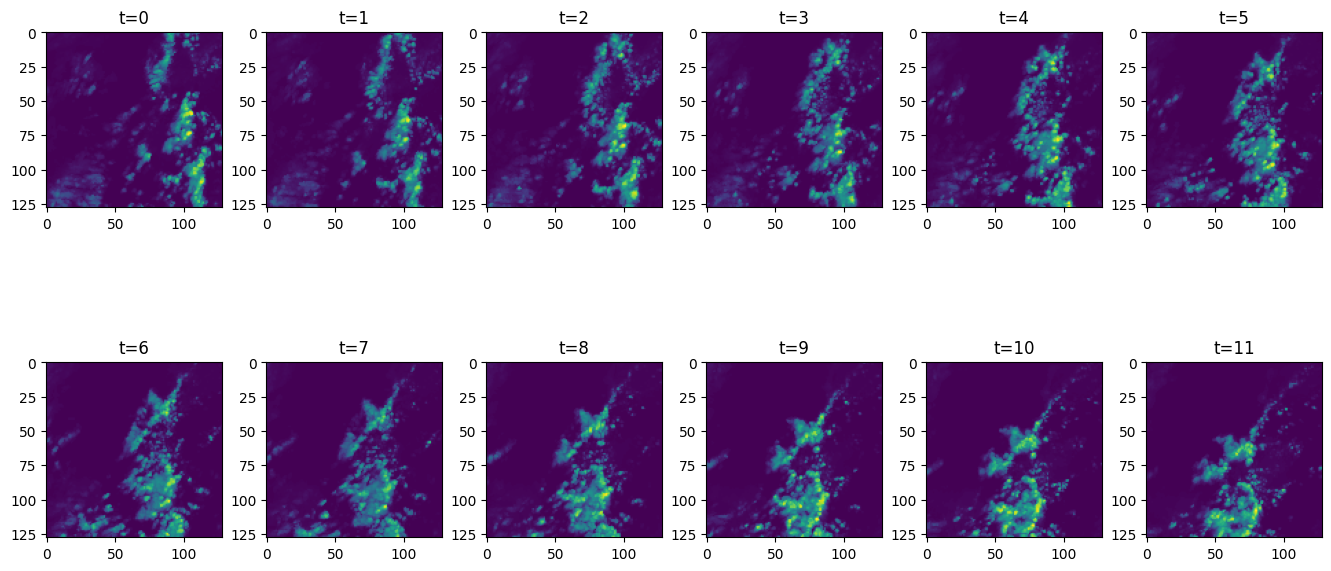

In [13]:
# Plot example
example_data = next(iter(train_loader)) # Shape (B, T, H, W, C). C=1.
example_data  = (example_data[0,:,:,:,0].detach().cpu().numpy() * SCALE + OFFSET)

fig, axs = plt.subplots(2, 6, figsize=(2.2*6, 6.6), constrained_layout=True)

for t in range(6):
    axs[0,t].imshow(example_data[t], origin="upper"); axs[0,t].set_title(f"t={t}")
    axs[1,t].imshow(example_data[6+t], origin="upper"); axs[1,t].set_title(f"t={6+t}")

plt.show()

# Get model

In [14]:
# FlowDAS models.py

# helpers functions
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d

def identity(t, *args, **kwargs):
    return t

def cycle(dl):
    while True:
        for data in dl:
            yield data

def has_int_squareroot(num):
    return (math.sqrt(num) ** 2) == num

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

def convert_image_to_fn(img_type, image):
    if image.mode != img_type:
        return image.convert(img_type)
    return image


# normalization functions
def normalize_to_neg_one_to_one(img):
    return img * 2 - 1

def unnormalize_to_zero_to_one(t):
    return (t + 1) * 0.5


# classifier free guidance functions
def uniform(shape, device):
    return torch.zeros(shape, device = device).float().uniform_(0, 1)

def prob_mask_like(shape, prob, device):
    if prob == 1:
        return torch.ones(shape, device = device, dtype = torch.bool)
    elif prob == 0:
        return torch.zeros(shape, device = device, dtype = torch.bool)
    else:
        return torch.zeros(shape, device = device).float().uniform_(0, 1) < prob


# small helper modules
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim, dim_out = None):
    return nn.Sequential(
        nn.Upsample(scale_factor = 2, mode = 'nearest'),
        nn.Conv2d(dim, default(dim_out, dim), 3, padding = 1)
    )

def Downsample(dim, dim_out = None):
    return nn.Conv2d(dim, default(dim_out, dim), 4, 2, 1)

class RMSNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.g = nn.Parameter(torch.ones(1, dim, 1, 1))

    def forward(self, x):
        return F.normalize(x, dim = 1) * self.g * (x.shape[1] ** 0.5)

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = RMSNorm(dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)


# sinusoidal positional embeds
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

class RandomOrLearnedSinusoidalPosEmb(nn.Module):
    """ following @crowsonkb 's lead with random (learned optional) sinusoidal pos emb """
    """ https://github.com/crowsonkb/v-diffusion-jax/blob/master/diffusion/models/danbooru_128.py#L8 """

    def __init__(self, dim, is_random = False):
        super().__init__()
        assert (dim % 2) == 0
        half_dim = dim // 2
        self.weights = nn.Parameter(torch.randn(half_dim), requires_grad = not is_random)

    def forward(self, x):
        x = rearrange(x, 'b -> b 1')
        freqs = x * rearrange(self.weights, 'd -> 1 d') * 2 * math.pi
        fouriered = torch.cat((freqs.sin(), freqs.cos()), dim = -1)
        fouriered = torch.cat((x, fouriered), dim = -1)
        return fouriered


# building block modules
class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

class ResnetBlock(nn.Module):
    def __init__(self, dim, dim_out, *, time_emb_dim, classes_emb_dim = None, groups = 8):
        super().__init__()

        assert time_emb_dim is not None
        assert time_emb_dim > 0

        int_time_emb_dim = int(time_emb_dim) 
        int_classes_emb_dim = int(classes_emb_dim) if classes_emb_dim is not None else 0
        int_both = int_time_emb_dim + int_classes_emb_dim

        self.mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(int_both, dim_out * 2)
        ) 

        self.block1 = Block(dim, dim_out, groups = groups)
        self.block2 = Block(dim_out, dim_out, groups = groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb = None, class_emb = None):

        scale_shift = None
        if exists(self.mlp) and (exists(time_emb) or exists(class_emb)):
            cond_emb = tuple(filter(exists, (time_emb, class_emb)))
            cond_emb = torch.cat(cond_emb, dim = -1)
            cond_emb = self.mlp(cond_emb)
            cond_emb = rearrange(cond_emb, 'b c -> b c 1 1')
            scale_shift = cond_emb.chunk(2, dim = 1)

        h = self.block1(x, scale_shift = scale_shift)

        h = self.block2(h)

        return h + self.res_conv(x)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads = 4, dim_head = 32):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias = False)

        self.to_out = nn.Sequential(
            nn.Conv2d(hidden_dim, dim, 1),
            RMSNorm(dim)
        )

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim = 1)
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> b h c (x y)', h = self.heads), qkv)

        q = q.softmax(dim = -2)
        k = k.softmax(dim = -1)

        q = q * self.scale

        context = torch.einsum('b h d n, b h e n -> b h d e', k, v)

        out = torch.einsum('b h d e, b h d n -> b h e n', context, q)
        out = rearrange(out, 'b h c (x y) -> b (h c) x y', h = self.heads, x = h, y = w)
        return self.to_out(out)

class Attention(nn.Module):
    def __init__(self, dim, heads = 4, dim_head = 32):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        hidden_dim = dim_head * heads

        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias = False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim = 1)
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> b h c (x y)', h = self.heads), qkv)

        q = q * self.scale

        sim = torch.einsum('b h d i, b h d j -> b h i j', q, k)
        attn = sim.softmax(dim = -1)
        out = torch.einsum('b h i j, b h d j -> b h i d', attn, v)

        out = rearrange(out, 'b h (x y) d -> b (h d) x y', x = h, y = w)
        return self.to_out(out)
        
class Unet(nn.Module):
    def __init__(
        self,
        num_classes,
        in_channels,
        out_channels,
        dim = 128,
        dim_mults = (1, 2, 2, 2), #,(1, 2, 4, 8),
        resnet_block_groups = 8,
        learned_sinusoidal_cond = True,
        random_fourier_features = False,
        learned_sinusoidal_dim = 32,
        attn_dim_head = 64,
        attn_heads = 4,
        use_classes = True,
    ):
        super().__init__()

        # determine dimensions

        self.use_classes = use_classes
        self.in_channels = in_channels
        input_channels = in_channels

        init_dim = dim
        self.init_conv = nn.Conv2d(input_channels, init_dim, 7, padding = 3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        block_klass = partial(ResnetBlock, groups = resnet_block_groups)

        # time embeddings
        time_dim = dim * 4

        self.random_or_learned_sinusoidal_cond = learned_sinusoidal_cond or random_fourier_features

        if self.random_or_learned_sinusoidal_cond:
            sinu_pos_emb = RandomOrLearnedSinusoidalPosEmb(learned_sinusoidal_dim, random_fourier_features)
            fourier_dim = learned_sinusoidal_dim + 1
        else:
            sinu_pos_emb = SinusoidalPosEmb(dim)
            fourier_dim = dim

        self.time_mlp = nn.Sequential(
            sinu_pos_emb,
            nn.Linear(fourier_dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim)
        )

        # class embeddings
        if self.use_classes:
            print("USING CLASSES IN UNET")

            self.classes_emb = nn.Embedding(num_classes, dim)

            classes_dim = dim * 4

            self.classes_mlp = nn.Sequential(
                nn.Linear(dim, classes_dim),
                nn.GELU(),
                nn.Linear(classes_dim, classes_dim)
            )
        else:
            print("NOT USING CLASSES IN UNET")
            classes_dim = None

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(nn.ModuleList([
                block_klass(dim_in, dim_in, time_emb_dim = time_dim, classes_emb_dim = classes_dim),
                block_klass(dim_in, dim_in, time_emb_dim = time_dim, classes_emb_dim = classes_dim),
                Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                Downsample(dim_in, dim_out) if not is_last else nn.Conv2d(dim_in, dim_out, 3, padding = 1)
            ]))

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim = time_dim, classes_emb_dim = classes_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim, dim_head = attn_dim_head, heads = attn_heads)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim = time_dim, classes_emb_dim = classes_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)

            self.ups.append(nn.ModuleList([
                block_klass(dim_out + dim_in, dim_out, time_emb_dim = time_dim, classes_emb_dim = classes_dim),
                block_klass(dim_out + dim_in, dim_out, time_emb_dim = time_dim, classes_emb_dim = classes_dim),
                Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                Upsample(dim_out, dim_in) if not is_last else  nn.Conv2d(dim_out, dim_in, 3, padding = 1)
            ]))

        self.out_channels = out_channels

        self.final_res_block = block_klass(dim * 2, dim, time_emb_dim = time_dim, classes_emb_dim = classes_dim)
        self.final_conv = nn.Conv2d(dim, self.out_channels, 1)

    def forward(self, x, time, classes = None):
        batch, device = x.shape[0], x.device

        if classes is not None:
            classes_emb = self.classes_emb(classes)
            c = self.classes_mlp(classes_emb)
        else:
            c = None
        x = self.init_conv(x)
        r = x.clone()
        t = self.time_mlp(time)
        h = []
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t, c)
            h.append(x)

            x = block2(x, t, c)
            x = attn(x)
            h.append(x)

            x = downsample(x)

        x = self.mid_block1(x, t, c)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t, c)

        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim = 1)
            x = block1(x, t, c)

            x = torch.cat((x, h.pop()), dim = 1)
            x = block2(x, t, c)
            x = attn(x)

            x = upsample(x)

        x = torch.cat((x, r), dim = 1)

        x = self.final_res_block(x, t, c)
        return self.final_conv(x)

In [15]:
# Main interpolant model

class DriftModel(nn.Module):
    def __init__(self, config):
        super(DriftModel, self).__init__()
        self.config = config
        c = config
        self._arch = Unet(
            num_classes = c.num_classes,
            ## 1
            in_channels = c.C * 7, # times two/(four for lookback condition 03/21/2025 chensiyi) for conditioning
            out_channels= c.C,
            # c.C =1
            dim = c.unet_channels,
            ## 128
            dim_mults = c.unet_dim_mults ,
            # (1, 2, 2, 2) 
            resnet_block_groups = c.unet_resnet_block_groups,
            # unet_resnet_block_groups = 8
            learned_sinusoidal_cond = c.unet_learned_sinusoidal_cond,
            # unet_learned_sinusoidal_cond = True
            random_fourier_features = c.unet_random_fourier_features,
            # unet_random_fourier_features = False
            learned_sinusoidal_dim = c.unet_learned_sinusoidal_dim,
            # unet_learned_sinusoidal_dim = 32
            attn_dim_head = c.unet_attn_dim_head,
            # unet_attn_dim_head = 64
            attn_heads = c.unet_attn_heads,
            # unet_attn_heads = 4
            use_classes = c.unet_use_classes,
            # unet_use_classes = False 
        )
        num_params = np.sum([int(np.prod(p.shape)) for p in self._arch.parameters()])
        print("Num params in main arch for drift is", f"{num_params:,}")

    def forward(self, zt, t, y, cond=None):
      
        if not self.config.unet_use_classes:
            y = None

        if cond is not None:
            zt = torch.cat([zt, cond], dim = 1)

        # print('input', zt.shape)
        out = self._arch(zt, t, y)

        return out

class Interpolant:

    def __init__(self, config):
        self.config = config

    def wide(self, t):
        return t[:, None, None, None]

    def alpha(self, t):
        return self.wide(1-t) 

    def alpha_dot(self, t):
        return self.wide(-1.0 * torch.ones_like(t))

    def beta(self, t):
        is_squared = self.config.beta_fn == 't^2'
        return self.wide(t.pow(2) if is_squared else t)

    def beta_dot(self, t):
        is_squared = self.config.beta_fn == 't^2'
        return self.wide(2.0 * t if is_squared else torch.ones_like(t))

    # we sometimes multiply sigma + sigma_dot by avg pixel norm, 
    # but when standardized (centered cifar), 
    # or when norm 1 (we rescale nse), not needed
    def sigma(self, t):
        return self.config.sigma_coef * self.wide(1-t) 

    def sigma_dot(self, t):
        return self.config.sigma_coef * self.wide(-torch.ones_like(t)) 
    
    def gamma(self, t):
        return self.wide(t.sqrt()) * self.sigma(t)

    def compute_zt(self, D):
        return D['at'] * D['z0'] + D['bt'] * D['z1'] + D['gamma_t'] * D['noise']

    def compute_zt_new(self, D): ## here use new because in the Dz0 has lookback frames rather than just z0 
        # print('z0', D['z0'][:,-1].shape)
        # print('z1', D['z1'].shape)
        # print(D['at'].squeeze(1).shape)
        # print((D['at'].squeeze(1) * D['z0'][:,-1]).shape)
        # print((D['bt'].squeeze(1) * D['z1']).shape)
        z0 = D['z0'][:,-1].unsqueeze(1)
        # print('zt_z0',z0.shape)
        if len(D['z1'].shape)==3:
            z1 = D['z1'].unsqueeze(1)
        else:
            z1 = D['z1']
        # print('zt_z1',z1.shape)
        # print('last term', (D['gamma_t'] * D['noise']).shape)
        return D['at'] * z0 + D['bt'] * z1 + D['gamma_t'] * D['noise']

    def compute_target(self, D):
        return D['adot'] * D['z0'] + D['bdot'] * D['z1'] +  (D['sdot'] * D['root_t']) * D['noise']

    def compute_target_new(self, D): ## here use new because in the Dz0 has lookback frames rather than just z0 
        z0 = D['z0'][:,-1].unsqueeze(1)
        # print('target_z0',z0.shape)
        z1 = D['z1']
        # print('target_z1',z1.shape)
        return D['adot'] * z0 + D['bdot'] * z1 +  (D['sdot'] * D['root_t']) * D['noise']
    
    def interpolant_coefs(self, D):
        return self(D)

    def __call__(self, D):
        D['at'] = self.alpha(D['t'])
        D['bt'] = self.beta(D['t'])
        D['adot'] = self.alpha_dot(D['t'])
        D['bdot'] = self.beta_dot(D['t'])
        D['root_t'] = self.wide(D['t'].sqrt())
        D['gamma_t'] = self.gamma(D['t'])
        D['st'] = self.sigma(D['t'])
        D['sdot'] = self.sigma_dot(D['t'])
        return D


In [17]:
# minimal config carrying only what's needed
c = SimpleNamespace(
    dataset='sevir',
    device=device,
    sigma_coef=1.0,
    beta_fn='t^2',
    t_min_sampling=0.0,
    t_max_sampling=0.999,
    EM_sample_steps=EM_STEPS,
    # UNet/arch (must match training)
    num_classes=1,
    C=1, H=128, W=128,
    unet_use_classes=False,
    unet_channels=128,
    unet_dim_mults=(1, 2, 2, 2),
    unet_resnet_block_groups=8,
    unet_learned_sinusoidal_dim=32,
    unet_attn_dim_head=64,
    unet_attn_heads=4,
    unet_learned_sinusoidal_cond=True,
    unet_random_fourier_features=False,
)

I = Interpolant(c)
model = DriftModel(c).to(device)
state = torch.load(CKPT_PATH, map_location=device)
model.load_state_dict(state['model_state_dict'])
model.eval()

NOT USING CLASSES IN UNET
Num params in main arch for drift is 30,020,113


DriftModel(
  (_arch): Unet(
    (init_conv): Conv2d(7, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (time_mlp): Sequential(
      (0): RandomOrLearnedSinusoidalPosEmb()
      (1): Linear(in_features=33, out_features=512, bias=True)
      (2): GELU(approximate='none')
      (3): Linear(in_features=512, out_features=512, bias=True)
    )
    (downs): ModuleList(
      (0): ModuleList(
        (0-1): 2 x ResnetBlock(
          (mlp): Sequential(
            (0): SiLU()
            (1): Linear(in_features=512, out_features=256, bias=True)
          )
          (block1): Block(
            (proj): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm): GroupNorm(8, 128, eps=1e-05, affine=True)
            (act): SiLU()
          )
          (block2): Block(
            (proj): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm): GroupNorm(8, 128, eps=1e-05, affine=True)
            (act): SiLU()
          )
 

# Model rollouts

In [21]:
mask = (torch.rand(1, 1, 1, 128, 128, device=device) < OBS_RATIO).float()  # broadcastable

def obs_operator(x):
    # x can be (B, 1, H, W), (B, T, 1, H, W), or (B, 1, 1, H, W)
    return x * mask  # broadcasting does the right thing

In [22]:
# Unguided sampling
@torch.no_grad()
def sample_unguided(base, cond, steps, sigma_fn, drift_fn):
    """
    base: (B,1,H,W)   most recent frame
    cond: (B,IN_LEN,1,H,W)  conditioning window used by the drift
    """
    B = base.shape[0]
    xt = base.clone()

    ts = torch.linspace(I.config.t_min_sampling, I.config.t_max_sampling, steps, device=xt.device)
    dt = ts[1] - ts[0]
    for t in ts:
        tvec = t.repeat(B)
        bF   = drift_fn(xt, tvec, cond)                      # (B,1,H,W)
        g    = sigma_fn(tvec).view(B,1,1,1)
        mu   = xt + bF * dt
        xt   = mu + g * torch.randn_like(mu) * dt.sqrt()
    return xt

In [35]:
# Guided sampling
def _taylor_est2rd_x1(xt, t, bF, cond, drift_fn):
    """
    The analytical second-order estimator used by the original code
    (MC_times == 1 path). t is (B,).
    """
    # noise term: 2/3 - sqrt(t) + (1/3)(sqrt(t))^3
    t_s   = torch.sqrt(t).view(-1,1,1,1)         # (B,1,1,1)
    eps_c = (2.0/3.0 - t_s + (1.0/3.0)*(t_s**3))
    hat   = xt + bF * (1 - t.view(-1,1,1,1)) + torch.randn_like(xt) * eps_c

    t1    = torch.ones_like(t)
    bF2   = drift_fn(hat, t1, cond)              # drift at t=1 for hat_x1
    hat   = xt + (bF + bF2) / 2 * (1 - t.view(-1,1,1,1)) + torch.randn_like(xt) * eps_c
    return hat.requires_grad_(True)


def _grad_and_value(x_prev, x0_hat, measurement):
    """
    measurement: (B,1,1,H,W)   observed (masked+noised) GT for this step in model scale
    x0_hat: (B,1,H,W)          estimate of x1 used to compute guidance gradient
    """
    # measurement is already noised operator(z1); in original they compute
    # (measurement - noiser(operator(x0_hat))). Here we apply the same structure:
    diff = (measurement - obs_operator(x0_hat.unsqueeze(1))).requires_grad_(True)  # (B,1,1,H,W)
    norm = torch.linalg.norm(diff)  # scalar
    grad = torch.autograd.grad(outputs=norm, inputs=x_prev, allow_unused=True)[0]
    return grad, norm


def sample_guided(base, cond, steps, sigma_fn, drift_fn, measurement, guidance_scale=0.1):
    """
    base: (B,1,H,W)
    cond: (B,IN_LEN,1,H,W)
    measurement: (B,1,1,H,W) for the current step (operator+noise on GT), in model scale
    """
    B = base.shape[0]
    xt = base.clone().requires_grad_(True)

    ts = torch.linspace(I.config.t_min_sampling, I.config.t_max_sampling, steps, device=xt.device)
    dt = ts[1] - ts[0]

    for t in ts:
        tvec = t.repeat(B)
        bF   = drift_fn(xt, tvec, cond).requires_grad_(True)
        g    = sigma_fn(tvec)                      # (B,)

        # 2nd-order estimate of x1
        hat_x1    = _taylor_est2rd_x1(xt, tvec, bF, cond, drift_fn)
        norm_grad, _ = _grad_and_value(xt, hat_x1, measurement)

        mu = xt + bF * dt
        g4 = g.view(B,1,1,1)
        if norm_grad is None:
            norm_grad = 0
        xt = mu + g4 * torch.randn_like(mu) * dt.sqrt() - guidance_scale * norm_grad

    return xt

In [24]:
# Functions for rollouts
def _drift_fn(xt, tvec, cond_time):
    # cond_time: (B, IN_LEN, 1, H, W) -> (B, IN_LEN, H, W)
    cond4 = cond_time.squeeze(2) if cond_time.dim() == 5 else cond_time
    return model(xt, tvec, None, cond=cond4)


def _sigma_fn(tvec):
    return I.sigma(tvec)


@torch.no_grad()
def rollout_unguided(z0_time, steps):
    """
    z0_time: (B, IN_LEN, 1, H, W)
    returns (B, steps, 1, H, W)
    """
    B = z0_time.shape[0]
    cond = z0_time.clone()
    outs = []
    for s in tqdm(range(steps)):
        base = cond[:, -1]              # (B,1,H,W)
        x1   = sample_unguided(base, cond, EM_STEPS, _sigma_fn, _drift_fn)
        outs.append(x1.unsqueeze(1))
        cond = torch.cat([cond[:, 1:], x1.unsqueeze(1)], dim=1)
    return torch.cat(outs, dim=1)


def rollout_guided(z0_time, steps, measurements, guidance_scale=0.1):
    """
    z0_time: (B, IN_LEN, 1, H, W)
    measurements: (B, steps, 1, H, W) in model scale; each step's masked+noised GT
    """
    B = z0_time.shape[0]
    cond = z0_time.clone()
    outs = []
    for s in tqdm(range(steps)):
        base = cond[:, -1]                  # (B,1,H,W)
        meas = measurements[:, s]           # (B,1,H,W) -> need (B,1,1,H,W) for our function
        x1   = sample_guided(base, cond, EM_STEPS, _sigma_fn, _drift_fn,
                             measurement=meas.unsqueeze(1), guidance_scale=guidance_scale)
        outs.append(x1.unsqueeze(1))
        cond = torch.cat([cond[:, 1:], x1.unsqueeze(1)], dim=1)
    return torch.cat(outs, dim=1)

In [33]:
example_data = next(iter(val_loader)) # Shape (B, T, H, W, C). C=1.
x0 = example_data[0, :IN_LEN, :, :, 0].unsqueeze(0).unsqueeze(2) # Shape (1, IN_LEN, 1, H, W)
x1 = example_data[0, IN_LEN:, :, :, 0].unsqueeze(0).unsqueeze(2) # Shape (1, OUT_LEN, 1, H, W)
z0 = (x0 - OFFSET) / SCALE
z1 = (x1 - OFFSET) / SCALE
z0, z1 = z0.to(device), z1.to(device)

# Note: for simplicity, in this example, data assimilation will be done in the normalized space (z)
with torch.no_grad():
    y = obs_operator(z1) + OBS_STD * torch.randn_like(z1) * mask

In [36]:
pred_unguided = rollout_unguided(z0, OUT_LEN)             # (1, OUT_LEN, 1, H, W)
pred_guided = rollout_guided(z0, OUT_LEN, y, OBS_STD)       # (1, OUT_LEN, 1, H, W)

100%|██████████| 6/6 [03:03<00:00, 30.53s/it]


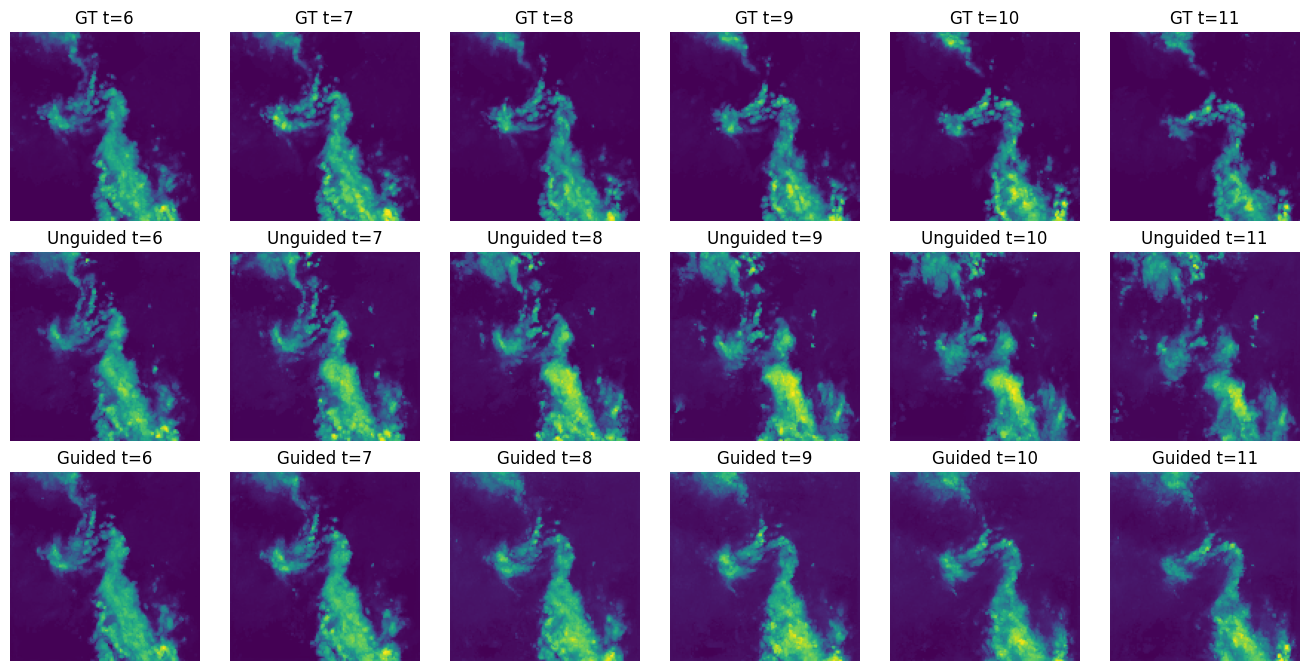

In [39]:
# convert back to display scale [0,1] like original visualization did: (x/10 + 0.5)
gt  = (z1[0,:,0].detach().cpu().numpy() * SCALE + OFFSET)
pg  = (pred_guided[0,:,0].detach().cpu().numpy() * SCALE + OFFSET)
pu  = (pred_unguided[0,:,0].detach().cpu().numpy() * SCALE + OFFSET)

T = OUT_LEN
fig, axs = plt.subplots(3, T, figsize=(2.2*T, 6.6), constrained_layout=True)

for t in range(T):
    axs[0, t].imshow(gt[t], origin="upper"); axs[0, t].set_title(f"GT t={6+t}");  axs[0, t].axis("off")
    axs[1, t].imshow(pu[t], origin="upper"); axs[1, t].set_title(f"Unguided t={6+t}"); axs[1, t].axis("off")
    axs[2, t].imshow(pg[t], origin="upper"); axs[2, t].set_title(f"Guided t={6+t}"); axs[2, t].axis("off")

plt.show()